<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/ThreeOrSeven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 4.9 MB/s 
     |████████████████████████████████| 197 kB 66.1 MB/s 
     |████████████████████████████████| 346 kB 63.9 MB/s 
     |████████████████████████████████| 1.2 MB 66.6 MB/s 
     |████████████████████████████████| 4.2 MB 61.5 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
     |████████████████████████████████| 1.1 MB 56.1 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 212 kB 70.1 MB/s 
     |████████████████████████████████| 127 kB 73.8 MB/s 
     |████████████████████████████████| 144 kB 75.9 MB/s 
     |████████████████████████████████| 271 kB 66.4 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.6 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [3]:
#Load in images of 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
#List things in the path
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [4]:
#Get image paths for 3s and 7s
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [5]:
#Show image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
#Image data can be represented in arrays
#Here is our image in a numpy array - showing rows and cols 4 through 10
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [7]:
#And now as a PyTorch Tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [9]:
#Use pandas to color code the values, giving us a better representation
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [10]:
#Store all image in tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

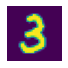

In [11]:
#use fastai show_image to display image in tensor
show_image(three_tensors[92])

In [12]:
#Our initial approach we are going to get average of all pixels
#To do this we will stack all images of each number into a single tensor
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

#Size gives us the length of each axis in a tensor
#Here we have count, pixels width, pixels height
stacked_threes.shape

torch.Size([6131, 28, 28])

In [13]:
#The length of the shape is a tensor's rank
len(stacked_threes.shape)

3

In [14]:
#Rank can also be accessed with ndim
stacked_threes.ndim 

3

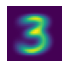

In [15]:
#To get the average of all images we call the mean method on dim 0 of stack
mean3 = stacked_threes.mean(0)
show_image(mean3)

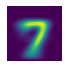

In [16]:
#Now for our set of 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [17]:
#We can test to see how far a test image is from the avg 3 or avg 7
a_3 = stacked_threes[2] #Test img
#Get absloute val of pixel differences to avoid cancellation of "too light" and "too dark"
dist_3_abs = (a_3 - mean3).abs().mean() #dist to avg 3
dist_7_abs = (a_3 - mean7).abs().mean() #dist to avg 7
dist_3_abs, dist_7_abs #Dist to 3 is smaller, so model picks 3

(tensor(0.1100), tensor(0.1541))

In [18]:
#We can do a similar thing by squaring the differences (to get a positive) then taking the root
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #to 3
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt() #to 7
dist_3_sqr, dist_7_sqr #again 3 is a better solution

(tensor(0.1980), tensor(0.2974))

In [19]:
#Pytorch already provides these as loss functions
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1541), tensor(0.2974))